# Oscillator model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import find_peaks
from scipy import interpolate
from scipy.ndimage import shift

plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams['figure.facecolor'] = 'white'

# import epde.interface.interface as epde_alg
# from epde.interface.prepared_tokens import CustomTokens, CacheStoredTokens

In [2]:
start_date, end_date = '2020-03-01', '2020-12-01'
# start_date, end_date = '2021-03-01', '2021-12-01'
# start_date, end_date = '2022-03-01', '2022-12-01'

In [3]:
data = pd.read_csv('../DATA-MINING/OTHER-DATA/TRANS/trans_big.csv')
data['TRANS_DATE'] = pd.to_datetime(data.date)
vallab = ['food', 'outfit', 'dwelling', 'health',
          'beauty', 'remote', 'travel', 'money',
          'kids', 'nonfood', 'telecom', 'fun',
          'charity', 'misc']
data = data[np.in1d(data.group.values, vallab)]
data.sort_values(by='date', inplace=True, ignore_index=True)
data.head()

,client,card,date,amt,mcc,group,value,TRANS_DATE
0,390989,3048567,2018-01-01,878.00,5814,food,survival,2018-01-01
1,1496081,2543555,2018-01-01,495.60,5499,food,survival,2018-01-01
2,2028714,2725479,2018-01-01,30000.00,6538,money,money,2018-01-01
3,1049186,366339,2018-01-01,619.00,5499,food,survival,2018-01-01
4,2625093,3267785,2018-01-01,1596.36,5411,food,survival,2018-01-01


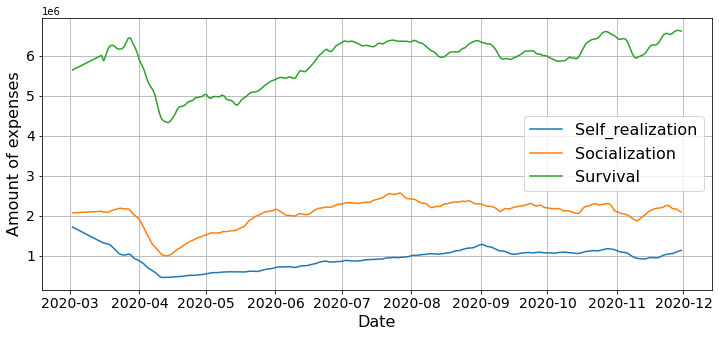

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
data['idate'] = pd.to_datetime(data.date)

d = data[(data.date>start_date)&(data.date<end_date)] \
    .groupby(['idate','value']) \
    .amt.sum().unstack() \
    .fillna(method='bfill')

plt.figure(figsize=(12,5))
for c in d.columns[1:]:
    sdec = seasonal_decompose(d[c],
                              period=14,
                              model='additive',
                              two_sided=False,
                              extrapolate_trend='freq')
    plt.plot(sdec.trend, label=c.capitalize())

plt.legend(fontsize=16)    
plt.grid()
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Date',size=16)
plt.ylabel('Amount of expenses',size=16)
plt.show()

In [5]:
d.head()

value,money,self_realization,socialization,survival
idate,,,,
2020-03-02,10049461.73,890817.73,1432264.07,4407375.33
2020-03-03,12284320.67,1041904.77,2064939.77,5106615.88
2020-03-04,9044432.64,1145389.43,1788901.93,4429023.82
2020-03-05,11117749.42,1487020.89,1698246.79,5421669.31
2020-03-06,16430241.58,1973282.34,2248633.90,6289421.33


## Calender

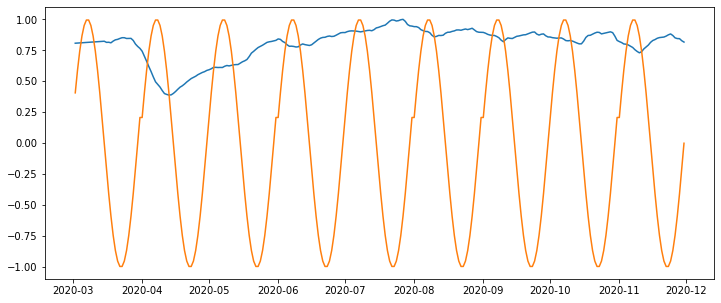

In [6]:
u = seasonal_decompose(d['socialization'],
                       period=14,
                       model='additive',
                       two_sided=False,
                       extrapolate_trend='freq').trend
u /= u.max() # normalization
dsin = np.sin(u.index.day.values*2*np.pi / 30)
dcos = np.cos(u.index.day.values*2*np.pi / 30)

t = np.linspace(0, len(u), len(u))
plt.figure(figsize=(12,5))
plt.plot(u)
plt.plot(pd.Series(dsin, index=u.index))

## PLACEHOLDER PARAMS

In [7]:
a = 0.037
b = 0.002

## EPDE parameter search

In [8]:
# boundary = 50
# dimensionality = u.ndim
# grids = np.meshgrid(t)

# epde_search_obj = epde_alg.epde_search(use_solver=False,
#                                        eq_search_iter=100,
#                                        dimensionality=dimensionality)
# epde_search_obj.fit(data=u.values, max_deriv_order=(2), boundary=boundary, 
#                     equation_terms_max_number=3, equation_factors_max_number=1,
#                     coordinate_tensors=grids, eq_sparsity_interval=(1e-8, 5.0),
#                     deriv_method='poly', deriv_method_kwargs={'smooth': True, 'grid': grids},
#                     memory_for_cache=25, prune_domain=False)

# res = epde_search_obj.equation_search_results(only_print=0, level_num=2)[0][0]
# a, b, c = -res.structure[0].weights_final

# print(f"a: {a}\nb: {b}")

Oscillator function:
$$X'' + aX' + bX = f(t)$$
where $X$ is the time series, $X'$ and $X''$ are its time derivatives, $a$ and $b$ are model parameters.

If $Z = X'$, then:
$$\begin{cases}
X'(t) = Z(t) + g(t) \\
Z'(t) = f(t) - aZ(t) - bX
\end{cases} \qquad g(t) \equiv 0$$

Vectorially speaking:
$$\frac{d}{dt} \begin{bmatrix} X \\ Z \end{bmatrix} = 
\begin{bmatrix} 0 & 1 \\ -b & -a \end{bmatrix} \cdot
\begin{bmatrix} X \\ Z \end{bmatrix} + 
\begin{bmatrix} g(t) \\ f(t) \end{bmatrix} \qquad g(t) \equiv 0$$

In this model, however, $g(t) \neq 0$, thus:
$$\underbrace{\frac{d}{dt} \begin{bmatrix} X \\ Z \end{bmatrix}}_{Y'} = 
\underbrace{\begin{bmatrix} 0 & 1 \\ -b & -a \end{bmatrix}}_{A} \cdot
\underbrace{\begin{bmatrix} X \\ Z \end{bmatrix}}_{Y} + 
\underbrace{\begin{bmatrix} g(t) \\ f(t) \end{bmatrix}}_{B}$$
$$Y' = A \cdot Y + B(t)$$

## News as initial state

In [9]:
news_path = '../DATA-PROCESSING/PROCESSED-DATA/TOPICS.csv'

news = pd.read_csv(news_path, sep=',', on_bad_lines='skip')
news.rename(columns={"Unnamed: 0": "date"}, inplace=True)
news['date'] = pd.to_datetime(news['date'])
news.sort_values(by='date', inplace=True, ignore_index=True)
cols = [1, 2]
news.drop(news.columns[cols], axis=1, inplace=True)

# Cubic spline interpolation for daily values
new_idx = pd.date_range(start=data['TRANS_DATE'].min(),
                        end=data['TRANS_DATE'].max(),
                        freq='D')
news.set_index('date', inplace=True)
news = news.reindex(news.index.union(new_idx)).interpolate(method='spline', order=3)
news = news.reindex(new_idx)

raw_news = news.copy()

news = news[(news.index>start_date)&(news.index<end_date)]

news.head()

,1_полиция_полицейски_наркотик,2_коронавиру_сутки_человек,3_год_2022_2020,4_белоруссия_ленинградс_область,5_мотоциклис_велосипеди_велосипед,6_парковка_парк_платный,7_театр_спектакль_мариинский,8_qr_код_цифровой,9_маска_носить_медицински,10_кафе_ресторан_кофе,...,39_стихотворе_стих_шнур,40_ситуация_стабилизац_стабилизир,41_бетономеша_бетонный_бетон,42_коррупция_борьба_коррупцион,43_четырехдне_рабочий_неделя,44_интернацио_парк_референдум,45_страховой_страховщик_страховка,46_оповещение_система_проверка,47_треугольни_красный_пожар,48_биометриче_биометрия_данные
2020-03-02,71.795032,80.028672,33.997682,14.866836,13.875866,28.313055,29.632396,7.523165,58.639014,10.256574,...,2.111053,1.679859,2.319116,3.214942,2.397671,2.539060,1.392131,2.449223,1.745828,0.379352
2020-03-03,71.433305,81.272783,33.756941,14.830901,13.813828,28.022213,29.935420,9.611972,59.389810,10.294852,...,2.110463,1.687781,2.289099,3.221490,2.380511,2.537266,1.391478,2.447224,1.745105,0.381797
2020-03-04,71.135198,82.515517,33.475487,14.788608,13.728295,27.753964,30.265475,11.871561,60.105619,10.335993,...,2.109872,1.695753,2.259880,3.228019,2.363427,2.535465,1.390822,2.445225,1.744384,0.384243
2020-03-05,70.896300,83.759173,33.155903,14.739862,13.622663,27.506958,30.620354,14.287966,60.791564,10.379862,...,2.109280,1.703773,2.231447,3.234521,2.346420,2.533659,1.390165,2.443227,1.743668,0.386691
2020-03-06,70.712199,85.006053,32.800772,14.684564,13.500330,27.279845,30.997850,16.847220,61.452764,10.426320,...,2.108688,1.711842,2.203785,3.240990,2.329491,2.531846,1.389505,2.441231,1.742955,0.389140


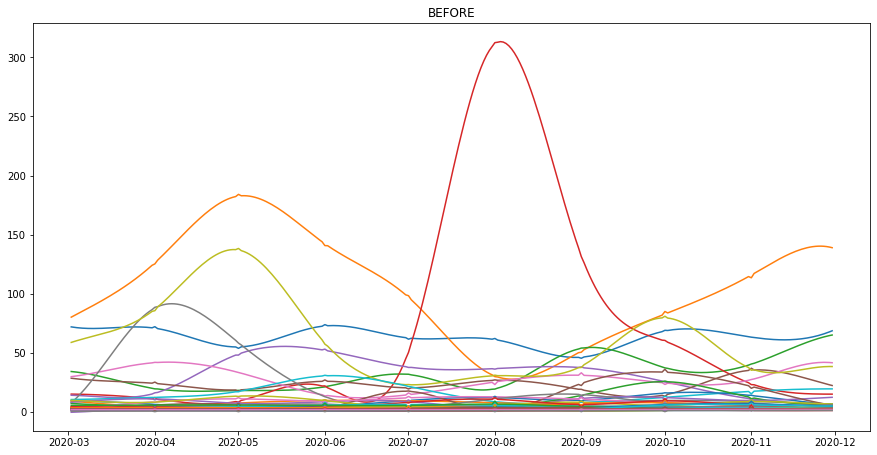

In [10]:
plt.plot(news);
plt.title("BEFORE")
news = news.ewm(span=20).mean()
raw_news = raw_news.ewm(span=20).mean()

Text(0.5, 1.0, 'AFTER')

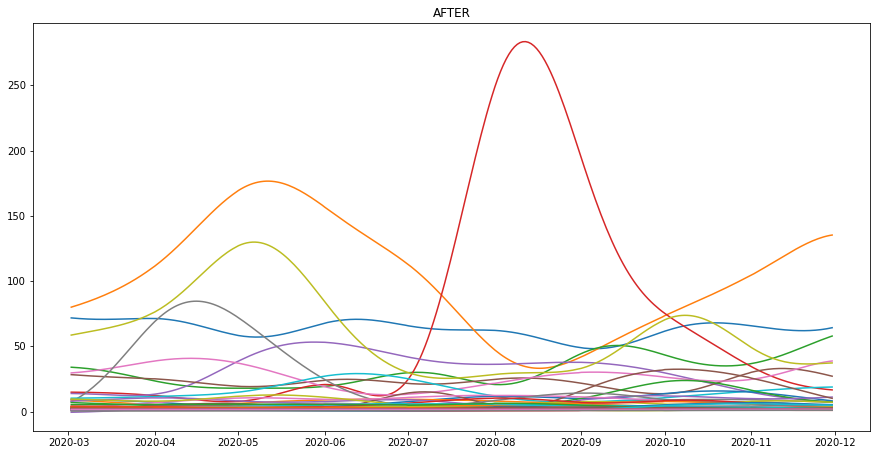

In [11]:
plt.plot(news);
plt.title("AFTER")

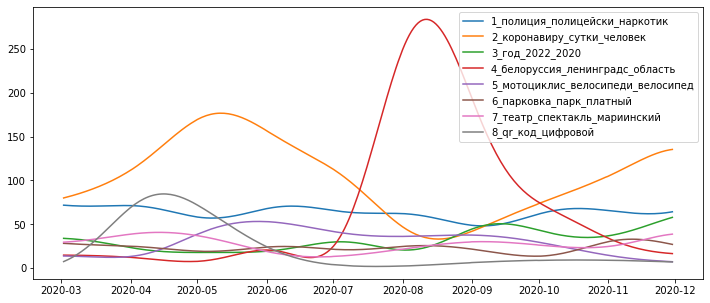

In [12]:
plt.figure(figsize=(12,5))
plt.plot(news.iloc[:,:8]);
plt.legend(news.columns[:8]);

## Runge-Kutta 4 solution

In [13]:
def fill_nan(arr):
    A = np.array(arr)
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

In [14]:
#fi, gi = 7, 1
def chooseContext(transactions, news, lagging=False):
    coeffs_gi = []
    coeffs_fi = []
    lags_gi = []
    lags_fi = []
    for col in news.columns:
        max_coef = 0
        min_coef = 0
        max_lag = 0
        min_lag = 0
        for lag in range(64):
            coef = news[col].corr(transactions.shift(lag))
            if coef > max_coef:
                max_coef = coef
                max_lag = lag
            if coef < min_coef:
                min_coef = coef
                min_lag = lag
        coeffs_gi.append(max_coef)
        coeffs_fi.append(min_coef)
        lags_gi.append(max_lag)
        lags_fi.append(min_lag)
    coeffs_gi = np.array(coeffs_gi)
    coeffs_fi = np.array(coeffs_fi)
    coeffs_gi /= coeffs_gi.sum()
    coeffs_fi /= coeffs_fi.sum()
    fi = np.zeros(len(news.iloc[:,0]))
    gi = np.zeros(len(news.iloc[:,0]))
    for i in range(len(coeffs_gi)):
        if lagging:
            cur_g = fill_nan(news.iloc[:,i].shift(lags_gi[i]))
            cur_f = fill_nan(news.iloc[:,i].shift(lags_fi[i]))
        else:
            cur_g = np.array(news.iloc[:,i])
            cur_f = np.array(news.iloc[:,i])
        fi += coeffs_fi[i] * cur_f
        gi += coeffs_gi[i] * cur_g
    return fi, gi

In [15]:
def normal(length=100, mu=0, sigma=1, boost=1):
    con = 1 / np.sqrt(2*np.pi*sigma)
    arr = [con*np.exp(-(item-mu)**2/(2*(sigma**2))) for item in range(length)]
    arr = np.array(arr)
    arr = arr/arr.max()*boost
    return arr

In [16]:
def squish(arr):
    return arr/arr.max()

In [17]:
def sharpen(arr, prom=0.8, width=20, extra=1.2):
    x = list(arr)
    peaks_p, _ = find_peaks(x, prominence=(None, prom))
    peaks_n, _ = find_peaks([-item for item in x], prominence=(None, prom))
    vals_p = [x[peak] for peak in peaks_p]
    vals_n = [x[peak] for peak in peaks_n]
    
    for idx, peak in enumerate(peaks_p):
        gaussian = normal(len(x), peak, width, vals_p[idx]*extra)
        x += gaussian

    for idx, peak in enumerate(peaks_n):
        gaussian = normal(len(x), peak, width, vals_n[idx]*extra)
        x -= gaussian
    
    x = np.array(x)
    return x, peaks_p, vals_p, peaks_n, vals_n

[13.30589554 13.39830662 13.4971106  13.60240618 13.71427322 13.83277185
 13.95794176 14.08980155 14.22834819 14.37355671]


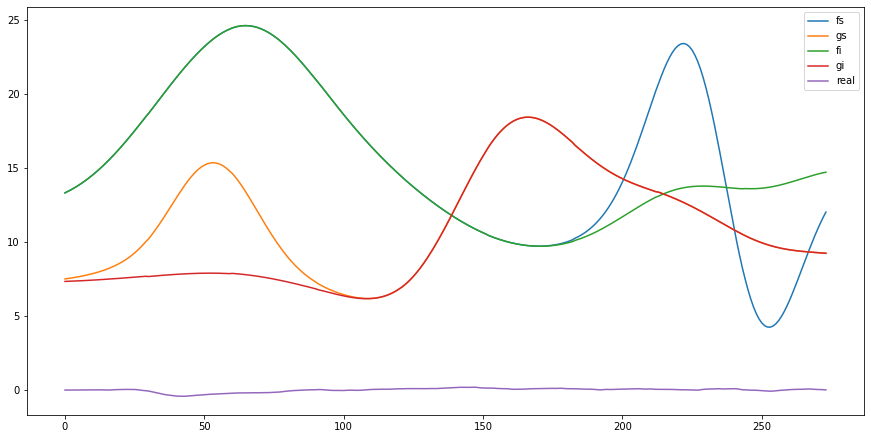

In [18]:
fi, gi = chooseContext((u-u[0]), news)
fs, _, _, _, _ = sharpen(fi, prom=0.9, width=15, extra=1.2)
gs, _, _, _, _ = sharpen(gi, prom=0.9, width=15, extra=1)

plt.plot(fs, label="fs")
plt.plot(gs, label="gs")
plt.plot(list(fi), label="fi")
plt.plot(list(gi), label="gi")
plt.plot(list((u-u[0])), label="real")
plt.legend()

print(fi[:10])

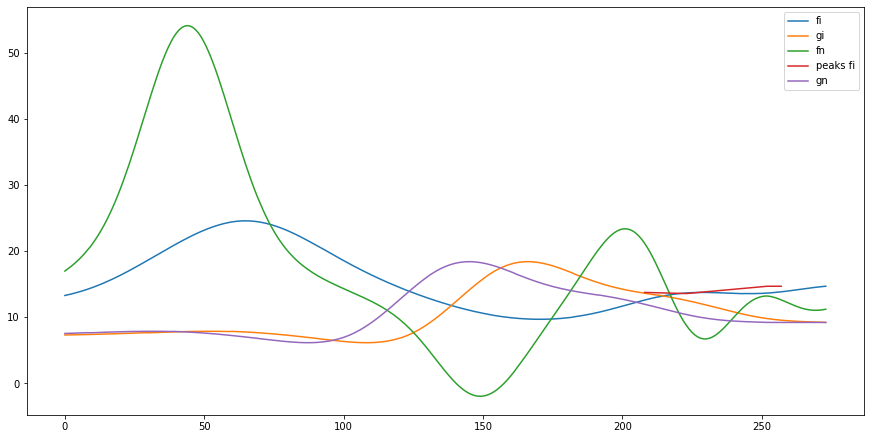

In [40]:
fi, gi = chooseContext((u-u[0]), news, lagging=False)

fn = shift(fi, -21, mode='nearest')
fn, _, _, _, _ = sharpen(fn, prom=100, width=15, extra=1.2)

gn = shift(gi, -21, mode='nearest')

plt.plot(list(fi), label="fi")
plt.plot(list(gi), label="gi")
plt.plot(list(fn), label="fn")
plt.plot(list(pe_p), list(va_p), label="peaks fi")
plt.plot(list(gn), label="gn")
plt.legend()

/home/dormant/.local/lib/python3.10/site-packages/scipy/optimize/_differentialevolution.py:533: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"


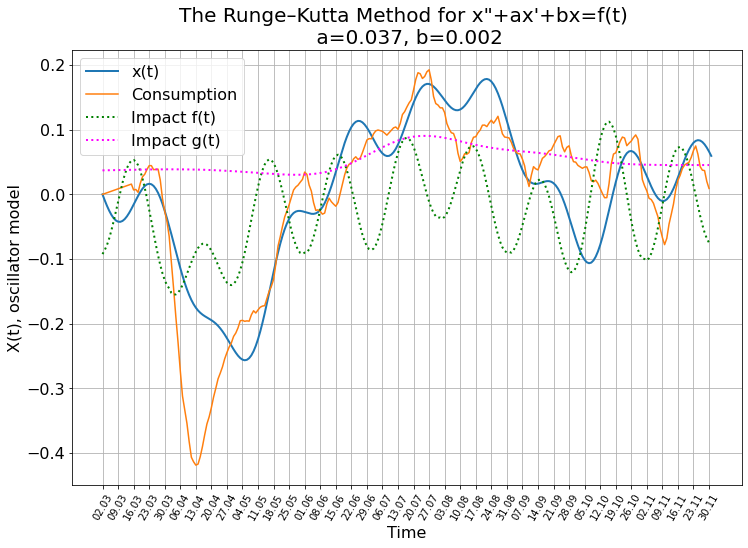

D = -0.01, h = 0.996
delta = 0.02, omega = 0.045
Elapsed time: 31.41356611251831 s


In [43]:
from scipy.optimize import differential_evolution    
import time

fi, gi = chooseContext((u-u[0]), news)
# PLACEHOLDERS
# fi += normal(len(fi), 40, 11, 40)

# fn = shift(fi, -21, mode='nearest')
# fn *= 3
# gi = shift(gi, -21, mode='nearest')

# NON-PLACEHOLDERS
fi = shift(fi, -21, mode='nearest')
fi, _, _, _, _ = sharpen(fi, prom=100, width=10, extra=5)
gi = shift(gi, -21, mode='nearest')

# Impact on X and X'
def f(t, a, b, c):
    # X------------------
    x = np.array(list(fi))#news.iloc[:,fi].to_list()) # qr code news
    x /= x.max()
    x = x[int(t)]
    # X'-----------------
    dx = np.array(list(gi))#news.iloc[:,gi].to_list()) # covid news
    dx /= dx.max()
    dx = dx[int(t)]
    # return [f(t), g(t)]
    return [a*x-b*dcos[int(t)-1], c*dx]

def train(args, final=False):
    x_bias, cos_bias, dx_bias = args[0], args[1], args[2]
    x = [0.0]     # Initial state of X(t)
    dx = [0.0]    # Initial state of dX/dt
    T = np.linspace(0, len(u)-1, len(u))
    h = (T[-1] - T[0]) / len(T)
    A = np.array([[0., 1.],
                  [-b, -a]])

    for t in T:
        Y = np.array([[x[-1],dx[-1]]]).T
        k1 = (np.dot(A,Y)+np.array([f(t, x_bias, cos_bias, dx_bias)]).T)*h
        k2 = (np.dot(A,(Y+k1/2))+np.array([f(t+h/2, x_bias, cos_bias, dx_bias)]).T)*h
        k3 = (np.dot(A,(Y+k2/2))+np.array([f(t+h/2, x_bias, cos_bias, dx_bias)]).T)*h
        k4 = (np.dot(A,(Y+k3))+np.array([f(t+h, x_bias, cos_bias, dx_bias)]).T)*h
        Y1 = Y+(k1+2*k2+2*k3+k4)/6
        x.append(Y1[0,0])
        dx.append(Y1[1,0])
    x = np.array(x)*b 
    dx = np.array(dx)*b 

    truth = np.array(u.values-u.values[0])
    pred = np.array(x[1:])
    loss = np.linalg.norm(pred - truth) / np.sqrt(len(truth))
    
#     print(f"x_bias: {x_bias :.3f} cos_bias: {cos_bias :.3f} dx_bias: {dx_bias :.3f} loss: {loss :.3f}%")
    
    if final:
        return x, T, h
    
    return loss

start_time = time.time()
# Diff evolution for optimization
# bounds = [(-15.0, 15.0), (-7.0, 10.0), (0.01, 1.0)]
bounds = [(-500.0, 500.0), (-200.0, 200.0), (0.0001, 1.0)]
result = differential_evolution(train, bounds, workers=4)
x_bias, cos_bias, dx_bias = result.x[0], result.x[1], result.x[2]

x, T, h = train([x_bias, cos_bias, dx_bias], final=True)

# Plotting
plt.figure(figsize=(12,8))
plt.plot(x, lw=2, label='x(t)')
#plt.plot(dx, lw=2, label='dx/dt')
plt.plot((u.values-u.values[0]), label='Consumption')
plt.plot([f(t, x_bias, cos_bias, dx_bias)[0]/50 for t in T], c='green', ls=':',lw=2,
         label='Impact f(t)')
plt.plot([f(t, x_bias, cos_bias, dx_bias)[1] for t in T], c='magenta', ls=':',lw=2,
         label='Impact g(t)')
xti=np.arange(0,len(T)+1,len(T)//8)
#plt.xticks(xti, np.arange(len(xti)), size=16)
t=np.arange(0,len(u),7)
plt.xticks(t, u.index.strftime('%d.%m').values[t], rotation=60)
plt.yticks(size=16)
plt.title('The Runge–Kutta Method for x\"+ax\'+bx=f(t) \n a=%.3f, b=%.3f'%(a,b), size=20)
plt.xlabel('Time', size=16)
plt.ylabel('X(t), oscillator model', size=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()
print('D = %.2f, h = %.3f'%(a**2-4*b, h))
print('delta = %.2f, omega = %.3f'%(a/2, np.sqrt(b)))
print(f"Elapsed time: {time.time() - start_time} s")